In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import sys

In [2]:
def pytorch_init():
    device_id = 1
    torch.cuda.set_device(device_id)
    
    # Sanity checks
    assert torch.cuda.current_device() == 1, 'Using wrong GPU'
    assert torch.cuda.device_count() == 2, 'Cannot find both GPUs'
    assert torch.cuda.get_device_name(0) == 'GeForce RTX 2080 Ti', 'Wrong GPU name'
    assert torch.cuda.is_available() == True, 'GPU not available'
    return torch.device('cuda', device_id)
    
device = pytorch_init()

To make a dataset class that is compatible with the torch.utils.data.DataLoader thing you should subclass **VisionDataset** from *torchvision.datasets.vision.VisionDataset* and implement *__getitem__* and *__len__*

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Returns a Dataset object
trainset = torchvision.datasets.CIFAR10(root='data', train=True,
                                        download=False, transform=transform)
# Equivalent to Tensorflow generators, 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=2,
                                          shuffle=True, num_workers=20)

testset = torchvision.datasets.CIFAR10(root='data', train=False,
                                       download=False, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=2,
                                         shuffle=False, num_workers=20)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

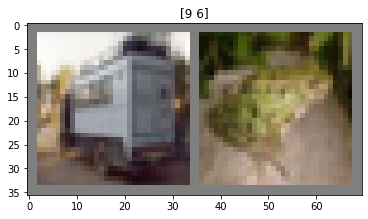

In [14]:
# function to show an image
def imshow(img, labels: list):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(labels)
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()


# show images
imshow(torchvision.utils.make_grid(images), str(labels.numpy()))

In [17]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # in_channels: Input channels (3 since RGB)
        # out_channels: Number of filters basically
        # kernel_size: u know what it is
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        # TODO: Figure out why 16*5*5, I believe you just need to know based on
        # input dimensions
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        
    def forward(self, x):
        print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        # Like reshape
        print(x.shape)
        x = x.view(-1 , 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Using nn.CrossEntropyLoss will kinda implicaitly apply some kind 
        # of softmax or something idk
        x = self.fc3(x)
        return x

# .to method can be use to cast to many different things, and is used to "cast" tensors to GPU 
net = Net().to(device)

In [18]:
net(images.to(device)).shape

torch.Size([2, 3, 32, 32])
torch.Size([2, 6, 14, 14])
torch.Size([2, 16, 5, 5])


torch.Size([2, 10])

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
net(images.to(device)).shape

In [ ]:
n_epochs = 60
for epoch in range(n_epochs):
    
    running_loss = 0.0
    
    bar = tqdm(
        iterable=enumerate(trainloader, 0), 
        total=len(trainloader), 
        unit=' batches',
        desc=f' Epoch {epoch+1}/{n_epochs}',
        file=sys.stdout,
        ascii=True,
        position=0
    )
    
    # Loop through batches
    for i, data in bar:
        inputs, labels = data[0].to(device), data[1].to(device)
                
        # Zero parameter gradients since PyTorch will just accumulate the gradient
        # vectors while it trains (in order to get the "mean" direction to move in
        # the parameter space). Also doing it this way minimizes memory allocation 
        # etc, probably. 
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward() # Computes gradients 
        optimizer.step() # Do a gradient step
        
        # print statistics
        running_loss += loss.item()
        bar.set_postfix({'loss':running_loss / (i+1)})

In [ ]:
torch.save(net.state_dict(), 'models/cifar_net.pth')

In [ ]:
# net.load_state_dict(torch.load('models/cifar_net.pth'))

In [ ]:
outputs = net(images.to(device))

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

62